In [33]:
from pathlib import Path
import fitsio
from cosmoprimo.fiducial import DESI
from pyrecon.utils import sky_to_cartesian, cartesian_to_sky, DistanceToRedshift
from acm.estimators import DensitySplit
from acm.utils import setup_logging
import numpy as np
import matplotlib.pyplot as plt


def read_cmass(filename, distance, zmin=0.45, zmax=0.6, is_random=False, weight_type=None):
    """Read CMASS LSS catalogues."""
    data = fitsio.read(filename)
    mask = (data['Z'] > zmin) & (data['Z'] < zmax)
    ra = data[mask]['RA']
    dec = data[mask]['DEC']
    redshift = data[mask]['Z']
    weights = np.ones(len(ra))
    if 'FKP' in weight_type:
        weights *= data[mask]['WEIGHT_FKP']
    if not is_random:
        if 'default' in weight_type:
            weights *= data[mask]['WEIGHT_SYSTOT'] * (data[mask]['WEIGHT_CP']
                    + data[mask]['WEIGHT_NOZ'] - 1)
    dist = distance(redshift)
    positions = sky_to_cartesian(dist=dist, ra=ra, dec=dec)
    return positions, weights

def save_quantiles(quantiles_positions, save_fn):
    quantiles_positions_sky = []
    for quantile in quantiles_positions:
        quantiles_dist, quantiles_ra, quantiles_dec = cartesian_to_sky(quantile)
        quantiles_redshift = d2r(quantiles_dist)
        quantiles_positions_sky.append(
            np.c_[quantiles_ra, quantiles_dec, quantiles_redshift]
        )
    np.save(output_fn, quantiles_positions_sky)


setup_logging()
cosmo = DESI()
distance = cosmo.comoving_radial_distance
d2r = DistanceToRedshift(distance)

zmin, zmax = 0.4, 0.7
region = 'South'
nrandoms = 5
weight_type='default_FKP'

# read data
data_dir = f'/pscratch/sd/e/epaillas/ds_boss/CMASS/'
data_fn = Path(data_dir) / f'galaxy_DR12v5_CMASS_{region}.fits.gz'
data_positions, data_weights = read_cmass(distance=distance, filename=data_fn,
                                          zmin=zmin, zmax=zmax, weight_type=weight_type)

# read randoms
randoms_dir = Path('/pscratch/sd/e/epaillas/ds_boss/CMASS/')
randoms_fn = randoms_dir / f'random0_DR12v5_CMASS_{region}.fits.gz'
randoms_positions, randoms_weights = read_cmass(distance=distance, filename=randoms_fn,
                                                zmin=zmin, zmax=zmax, is_random=True, weight_type=weight_type)

[000240.85]  04-12 19:08  DensitySplit                 INFO     Initializing DensitySplit.
[000240.89]  04-12 19:08  DensitySplit                 INFO     Box size: [1490. 3625. 2040.]
[000240.89]  04-12 19:08  DensitySplit                 INFO     Box center: [1246.46296135   21.62158482  348.22434843]
[000240.89]  04-12 19:08  DensitySplit                 INFO     Box nmesh: [298 725 408]
[000241.78]  04-12 19:08  DensitySplit                 INFO     Setting density contrast.
[000275.04]  04-12 19:08  FFTWEngine                   INFO     Saving wisdom to wisdom.shape-298-725-408.type-float64.nthreads-4.npy.
[000276.42]  04-12 19:08  FFTWEngine                   INFO     Loading wisdom from wisdom.shape-298-725-408.type-float64.nthreads-4.npy.
[000276.42]  04-12 19:08  FFTWEngine                   INFO     Saving wisdom to wisdom.shape-298-725-408.type-float64.nthreads-4.npy.
[000278.39]  04-12 19:08  DensitySplit                 INFO     Quantiles calculated in 0.15 seconds.


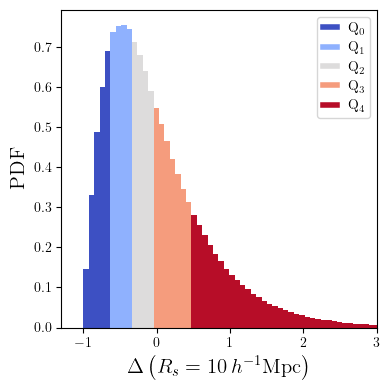

In [34]:
nquery = 5 * len(data_positions)
idx = np.random.choice(len(randoms_positions), size=nquery)
query_positions = randoms_positions[idx]

ds = DensitySplit(positions=randoms_positions, cellsize=5.0)
ds.assign_data(positions=data_positions, weights=data_weights)
ds.assign_randoms(positions=randoms_positions, weights=randoms_weights)
ds.set_density_contrast(smoothing_radius=10)
quantiles, quantiles_idx, delta = ds.set_quantiles(nquantiles=5, query_positions=query_positions)

ds.plot_quantiles()
plt.show()

# save to disk
output_dir = '/pscratch/sd/e/epaillas/ds_boss/ds_quantiles/CMASS'
output_fn = Path(output_dir) / f'quantiles_CMASS_{region}_{zmin}_{zmax}_{weight_type}.npy'
save_quantiles(quantiles, output_fn)

[000341.13]  04-12 19:09  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000341.13]  04-12 19:09  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000341.13]  04-12 19:09  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000341.43]  04-12 19:09  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000345.50]  04-12 19:09  TwoPointCorrelationFunction  INFO     Computing two-point counts R1D2.
[000350.36]  04-12 19:10  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000437.28]  04-12 19:11  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 96.15 s.
[000437.28]  04-12 19:11  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000437.28]  04-12 19:11  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000437.28]  04-12 

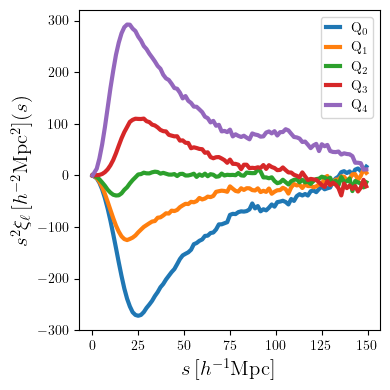

In [35]:
sedges = np.linspace(0, 150, 100)
muedges = np.linspace(-1, 1, 241)
ds.quantile_data_correlation(data_positions=data_positions, randoms_positions=randoms_positions,
                             data_weights=data_weights, randoms_weights=randoms_weights,
                             edges=(sedges, muedges), los='midpoint', nthreads=4, gpu=True)
ds.plot_quantile_data_correlation(ell=0)
plt.show()